In [1]:
#!pip install tensorflow
#!pip install tf-keras
#%pip install torch
#%pip install transformers

import pandas as pd
import numpy as np

In [3]:
df_tweets = pd.read_csv(r"C:\Users\Administrator\2024_nus_Financial AI\stock_tweets\stock_tweets.csv")
# 读取CSV文件中的推特数据
df_tweets.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
df_apple = df_tweets[df_tweets["Stock Name"] == "APPL"].copy()# 过滤出与苹果公司（AAPL）相关的推特数据
df_apple

,Date,Tweet,Stock Name,Company Name


In [7]:
import torch
print(torch.__version__)

2.4.1+cpu


In [8]:
from transformers import AutoModel, AutoTokenizer
from transformers import pipeline, AutoModelForSequenceClassification

# Model used: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21
# Load tokenizer and model from Hugging Face Hub
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
# for getting embeddings, it is important to have output_hidden_states=True, otherwise, you wont get embeddings

# Create a sentiment analysis pipeline using the loaded model and tokenizer
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Label_2: Positive
# Label_1: Neutral
# Label_0: Negative 
results_apple = [(tweet, sentiment_pipeline(tweet)) for tweet in df_apple["Tweet"]]
results_apple

# ~ 15 mins

C:\Users\Administrator\2024_nus_Financial AI\ML\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /cardiffnlp/twitter-roberta-base-sentiment-latest/resolve/main/tokenizer_config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))"), '(Request ID: 43e81d9f-1a8b-459f-b205-8b2adb822e02)')

In [22]:
final_scores = []
for result in results_apple:
    sentiment = result[1][0]
    label = sentiment["label"]
    score = sentiment["score"]

    # LABEL_0: Negative
    # LABEL_1: Neutral
    # LABEL_2: Positive
    if label == "positive":
        final_scores.append(score)
    elif label == "negative":
        final_scores.append(-1*score)
    else:
        final_scores.append(0)
df_apple.loc[:,"score"] = final_scores
df_apple

# Score of 1: Very positive about Apple
# Score of 0: Very neutral about Apple
# Score of -1: Very negative about Apple

,Date,Tweet,Stock Name,Company Name,score
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,-0.482336
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,0.000000
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,0.000000
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,-0.571210
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,0.000000
...,...,...,...,...,...
61009,2021-09-30 15:37:52+00:00,"All about this trendline now on $AAPL, continu...",AAPL,Apple Inc.,-0.708965
61010,2021-09-30 15:30:03+00:00,This thread is just a broad overview of the ba...,AAPL,Apple Inc.,0.000000
61011,2021-09-30 13:36:10+00:00,"In 2020, Tim Cook, CEO of $AAPL, earned $265,0...",AAPL,Apple Inc.,0.578797
61012,2021-09-30 10:22:53+00:00,The media is really pushing hard for their big...,AAPL,Apple Inc.,-0.799822


In [29]:
df_apple.describe()

,score
count,5056.000000
mean,0.140433
std,0.472985
min,-0.944193
25%,0.000000
50%,0.000000
75%,0.587643
max,0.990013


In [49]:
#%pip install pandas-datareader
#%pip install yfinance
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# INDIVIDUAL METHOD:

#nvda = pdr.get_data_yahoo("NVDA", start=datetime.datetime(2018, 1, 1), 
#                          end=datetime.datetime(2024, 1, 1))
#amzn = pdr.get_data_yahoo("AMZN", start=datetime.datetime(2018, 1, 1), 
#                          end=datetime.datetime(2024, 1, 1))
#meta = pdr.get_data_yahoo("META", start=datetime.datetime(2018, 1, 1), 
#                          end=datetime.datetime(2024, 1, 1))

#nvda.head()

# COLLECTIVE METHOD:

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL']
aapl_stock = get(tickers, datetime.datetime(2018, 10, 1), datetime.datetime(2024, 1, 1))
aapl_stock = aapl_stock.reset_index(level='Ticker', drop=True).reset_index()
aapl_stock.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-01,56.987499,57.355000,56.587502,56.814999,54.199284,94403200
1,2018-10-02,56.812500,57.500000,56.657501,57.320000,54.681023,99152800
2,2018-10-03,57.512501,58.367500,57.445000,58.017502,55.346420,114619200
3,2018-10-04,57.695000,58.087502,56.682499,56.997501,54.373379,128168000
4,2018-10-05,56.990002,57.102501,55.145000,56.072498,53.490955,134322000


aapl_stock Date Range: 2018-10-01 00:00:00 to 2023-12-29 00:00:00
df_apple Date Range: 2021-09-30 00:00:00 to 2022-09-29 00:00:00
Number of rows in df_merged: 252


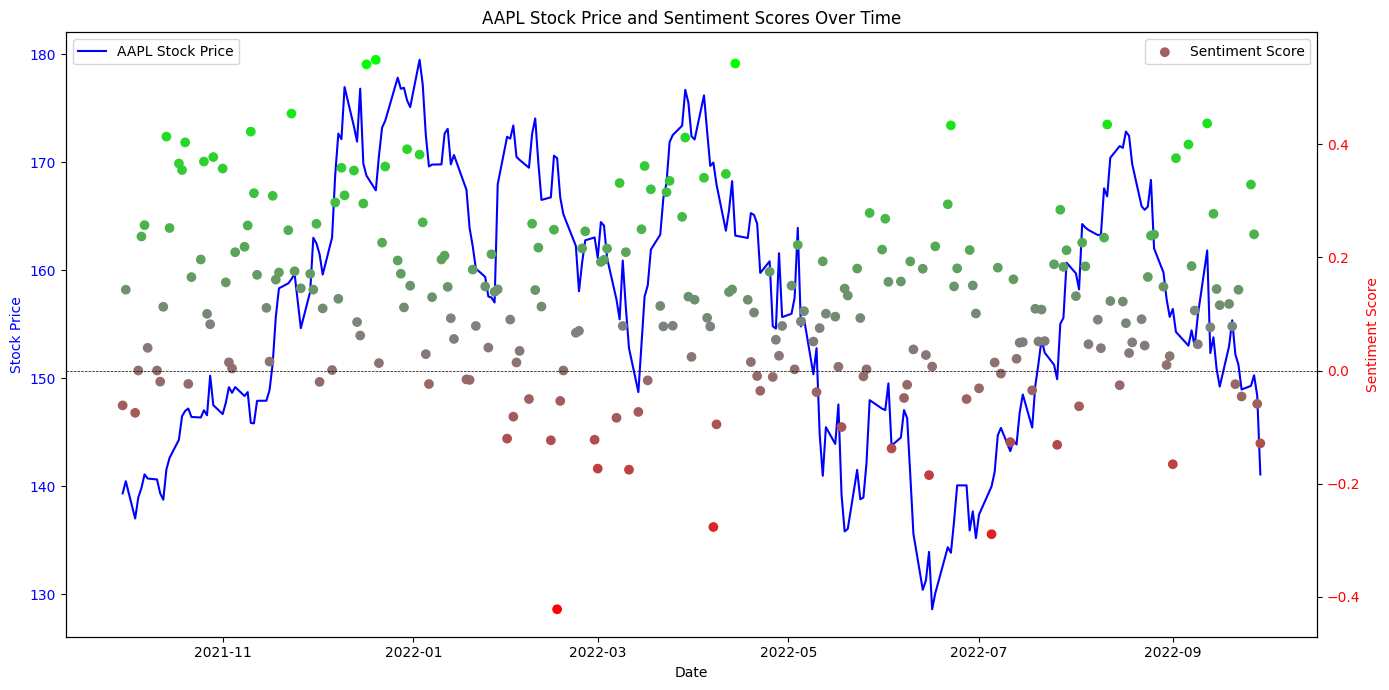

In [68]:
#%pip install seaborn
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

df_apple['Date'] = pd.to_datetime(df_apple['Date']).dt.normalize()
aapl_stock['Date'] = pd.to_datetime(aapl_stock['Date']).dt.normalize()

# Check date ranges of both dataframes
print("aapl_stock Date Range:", aapl_stock['Date'].min(), "to", aapl_stock['Date'].max())
print("df_apple Date Range:", df_apple['Date'].min(), "to", df_apple['Date'].max())

# Filter df_apple to only include dates within the aapl_stock date range
df_apple_filtered = df_apple[(df_apple['Date'] >= aapl_stock['Date'].min()) & (df_apple['Date'] <= aapl_stock['Date'].max())]

# Aggregate sentiment scores by taking the mean for each date
df_apple_agg = df_apple_filtered.groupby('Date').agg({'score': 'mean'}).reset_index()

# Merge the aggregated df_apple with aapl_stock on Date
df_merged = pd.merge(aapl_stock, df_apple_agg, on='Date', how='inner')

# Check number of rows in the merged dataframe
print("Number of rows in df_merged:", len(df_merged))

# Define a custom color map
colors = [(1, 0, 0), (0.5, 0.5, 0.5), (0, 1, 0)]  # R -> Gray -> G
n_bins = 100  # Discretize the color map into 100 bins
cmap_name = 'sentiment_cmap'
sentiment_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Normalize the sentiment scores to [0, 1] for color mapping
norm = plt.Normalize(df_merged['score'].min(), df_merged['score'].max())
sm = plt.cm.ScalarMappable(cmap=sentiment_cmap, norm=norm)
df_merged['color'] = df_merged['score'].apply(lambda x: sm.to_rgba(x))

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock prices (e.g., Adj Close) on the primary y-axis
sns.lineplot(x='Date', y='Adj Close', data=df_merged, ax=ax1, color='blue', label='AAPL Stock Price')
ax1.set_ylabel('Stock Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot sentiment scores on the secondary y-axis
ax2 = ax1.twinx()
ax2.scatter(df_merged['Date'], df_merged['score'], color=df_merged['color'], label='Sentiment Score')
ax2.axhline(y=0.0, color='black', linestyle='--', linewidth=0.5)  # Add horizontal line at sentiment score 0.0
ax2.set_ylabel('Sentiment Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legends
plt.title('AAPL Stock Price and Sentiment Scores Over Time')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
# NOTE: This code is only to process both Apple's and Tesla's stock.
# This code takes longer to do. I (Kian) will work with both stocks in the near future. For now, it's just Apple.

df_apple = df_tweets[df_tweets["Stock Name"] == "AAPL"]

# Filter for Tesla tweets and sample 5056 tweets
df_tesla = df_tweets[df_tweets["Stock Name"] == "TSLA"].sample(n=5056, random_state=1)

# Concatenate the Apple and sampled Tesla tweets
df_apple_tesla = pd.concat([df_apple, df_tesla]).reset_index(drop=True)

# Display the resulting DataFrame
print(df_apple_tesla)